# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp ffp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.interpolate import interp1d


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export

# Disk Density
def zthin(r):
    if r > 4.5:
        return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
    else:
        return zthin45

def rho_thin(r, z):
    if r > rdBreak:
        return rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((r - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2
    else:
        return rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((rdBreak - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2

def rho_thick(r, z):
    if r > rdBreak:
        return rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))
    else:
        return rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))

# Bulge Density
def rsf(xp, yp, zp):
    R = (xp**cperp / x0**cperp + yp**cperp / y0**cperp)**(cpar/cperp) + (zp / z0)**cpar
    return R**(1/cpar)

def fE(xp, yp, zp):
    return np.exp(-rsf(xp, yp, zp))

def cut(x):
    if x > 0:
        return np.exp(-x**2)
    else:
        return 1

def rho_bulge(xp, yp, zp):
    R = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((R - Rc) / 0.5)

def rho_bulge(d):
    xp, yp = get_primed_coords(d)
    zp = 0
    R = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((R - Rc) / 0.5)

# Total FFP Density
def rho_FFPs(d: float, # distance from Sun in kpc
             ) -> float: # FFP density in Msun/kpc^3
    # TODO Need to weight this by number of FFPs per star and mass of FFPs
    r = dist_mw(d)
    z = 0
    return rho_thin(r, z) + rho_thick(r, z) + rho_bulge(d)



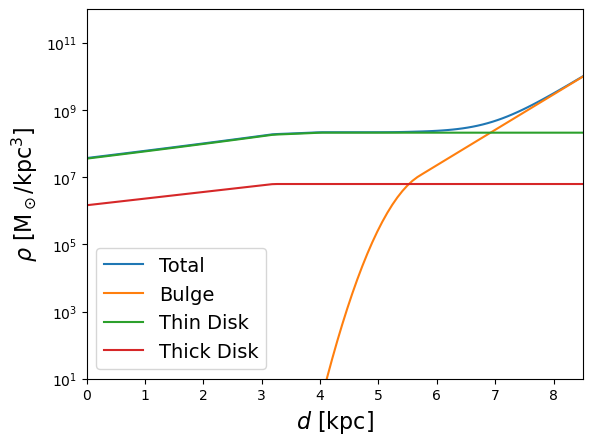

In [ ]:
# Define values for the x-axis
d = np.linspace(0, rEarth, num=100)
z = 0
# Calculate the density values for each component
rho_total_arr = [rho_FFPs(i) for i in d]
rho_bulge_arr = [rho_bulge(i) for i in d]
rho_thin_arr = [rho_thin(dist_mw(i), z) for i in d]
rho_thick_arr = [rho_thick(dist_mw(i), z) for i in d]

# Create the log plot
plt.plot(d, rho_total_arr, label="Total")
plt.plot(d, rho_bulge_arr, label="Bulge")
plt.plot(d, rho_thin_arr, label="Thin Disk")
plt.plot(d, rho_thick_arr, label="Thick Disk")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(0, rEarth)
plt.ylim(1e1, 1e12)

# Show the plot
plt.show()


In [ ]:
#| export
options = {"epsabs": 1e-10, "epsrel": 1e-10}

def dGdt_FFP(t, mFFP):
    def integrand(umin, d):
        return 1 / (ut**2 - umin**2)**(1/2) * rho_FFPs(d) / \
               (mFFP * velocity_dispersion(d)**2) * velocity_radial(d, mFFP, umin, t * htosec)**4 * \
               (htosec / kpctokm)**2 * np.exp(-velocity_radial(d, mFFP, umin, t * htosec)**2 / velocity_dispersion(d)**2)
    result, _ = nquad(integrand, [(0, ut), (0, rEarth)], opts=options)
    return 2 * result

## Perform Weighted Sum over FFP distribution

In [ ]:
#| export
class Ffp:
    
    def __init__(self, 
                 mlow: float, # lower mass limit in solar masses
                 alpha: float, # power law slope of distribution
                 ): 
        self.mlow = mlow
        self.alpha = alpha
        self.sample_masses = self.generate_sample(int(1e4))
        self.tE_interp = None
    
    def __str__(self):
        return f"FFP: mlow={self.mlow}, alpha={self.alpha}"
    __repr__ = __str__

    def generate_sample(self, 
                        n: int = int(1e4) # number of samples
                        ):
        return self.mlow * (1 - np.random.rand(int(n)))**(-1 / (self.alpha - 1))
    

    def get_ffp_pdf(self,
                    n_bins: int = 10, # number of mass bins
                    ):
        
        bins = np.logspace(np.log10(self.mlow), np.log10(np.max(self.sample_masses) * 1.01), num=n_bins)
        counts, hist_bins, = np.histogram(self.sample_masses, bins=bins, density=True)
        bin_centers = (hist_bins[1:] + hist_bins[:-1]) / 2
        ffpPDF = np.zeros((len(counts), len(bin_centers)))
        ffpPDF[0] = counts/np.sum(counts)
        ffpPDF[1] = bin_centers
        return ffpPDF
    
    def get_weighted_te(self,
                        n_bins: int = 10, # number of mass bins
                        ):
        ffpPDF = self.get_ffp_pdf(n_bins)
        tMin = 1e-2  # hours
        tMax = 1e3
        n_t_bins = 10
        tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=n_t_bins)

        tETable = np.zeros((len(ffpPDF[0])-1, len(tBins)))
        for i in range(len(ffpPDF[0])-1):
            for j in range(len(tBins)):
                tETable[i,j] = ffpPDF[0][i] * dGdt_FFP(tBins[j], ffpPDF[1][i])

        tEWeighted = np.sum(tETable, axis=0)
        # tEInterp = interp1d(np.log10(tBins), np.log10(tEWeighted), kind="cubic")
        return tBins, tEWeighted
    
    def make_te_interp(self,
                       n_bins: int = 10, # number of mass bins
                       ):
        tBins, tEWeighted = self.get_weighted_te(n_bins)
        tEInterp = interp1d(np.log10(tBins), np.log10(tEWeighted), kind="cubic")
        self.tE_interp = tEInterp
    
    def differential_rate(self, t):
        if self.tE_interp is None:
            self.make_te_interp()
        return 10**self.tE_interp(np.log10(t))



In [ ]:
mMin = 1e-5  # solar masses
alpha = 2
f = Ffp(mMin, alpha)
f

FFP: mlow=1e-05, alpha=2

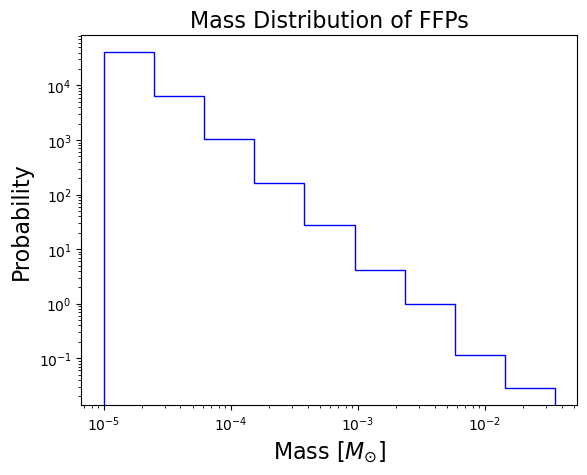

In [ ]:
nBins = 10
tMin = 1e-2  # hours
tMax = 1e3
ntBins = 10

f.generate_sample()
mSample = f.sample_masses
tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=ntBins)
bins = np.logspace(np.log10(mMin), np.log10(np.max(mSample) * 1.01), num=nBins)
hist, bins = np.histogram(mSample, bins=bins, density=True)

plt.hist(mSample, bins=bins, density=True, histtype="step", color="blue")

plt.xlabel("Mass [$M_{\odot}$]", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.title("Mass Distribution of FFPs", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
f.make_te_interp(n_bins=10)

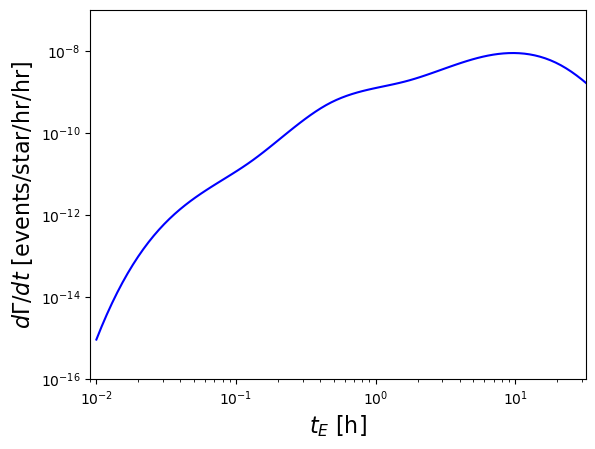

In [ ]:
t = np.logspace(-2, np.log10(5e1), num=100)
diff_rates = f.differential_rate(t)

plt.loglog(t, diff_rates, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 32])
plt.ylim([1e-16, 1e-7])
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()